## Multi-Layer Perceptron
### Ziad Al-Ziadi

#### In this notebook, we will build three separate MLP models to evaluate and then run them all through a grid search to see whether any improvements can be found. Both the initial MLP and the grid search MLP will be evaluated on Train and Validation sets to see which is the most optimal. The optimal MLP will then be tested in the Best_models notebook along with the optimal SVM.

In [1]:
# Importing relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim 
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss, MSELoss
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F 

import skorch
from skorch import NeuralNetClassifier

from sklearn.metrics import log_loss, roc_auc_score, plot_confusion_matrix, plot_roc_curve,classification_report, confusion_matrix, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", 250)

In [2]:
# Reading in the dataset

path = "diabetes.csv"

diabetes = pd.read_csv(path)

In [3]:
# Whilst conduting EDA, we discovered a large amount of '0' values in for some important variables. Therefore it was
# decided to impute these '0' values with the mean value for the respective variable

postive = diabetes.loc[diabetes["Outcome"] == 1] # has diabetes
negative = diabetes.loc[diabetes["Outcome"] == 0] # does not have diabetes

In [4]:
postive = postive.replace({"Glucose": 0},
                            np.mean(postive["Glucose"]))

postive = postive.replace({"BloodPressure": 0},
                            np.mean(postive["BloodPressure"]))


postive = postive.replace({"SkinThickness": 0},
                            np.mean(postive["SkinThickness"]))

postive = postive.replace({"BMI": 0},
                            np.mean(postive["BMI"]))

postive = postive.replace({"Insulin": 0},
                            np.mean(postive["Insulin"]))

In [5]:
negative = negative.replace({"Glucose": 0},
                            np.mean(negative["Glucose"]))

negative = negative.replace({"BloodPressure": 0},
                            np.mean(negative["BloodPressure"]))


negative = negative.replace({"SkinThickness": 0},
                            np.mean(negative["SkinThickness"]))

negative = negative.replace({"BMI": 0},
                            np.mean(negative["BMI"]))

negative = negative.replace({"Insulin": 0},
                            np.mean(negative["Insulin"]))

In [6]:
diabetes = pd.concat([postive, negative]) # now our datasets has no missing values

In [7]:
y = diabetes["Outcome"]
diabetes.drop(["Outcome"], axis = 1, inplace = True)
X = diabetes

# Creating our test, train and validation sets from the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X, X_validation, y, y_validation = train_test_split(X_train, y_train, test_size = 0.25,random_state = 42)

In [8]:
# Now we normalise our data - we normalise our sets separately to minimise information loss
scaler = StandardScaler()

scaler.fit_transform(X_train)
scaler.fit_transform(X_test)
scaler.fit_transform(X_validation)

# here we convert our sets to tensors 

X_train = torch.Tensor(X_train.to_numpy())
X_test = torch.Tensor(X_test.to_numpy())
X_validation = torch.Tensor(X_validation.to_numpy())

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
X_validation = torch.FloatTensor(X_validation)

y_train = torch.LongTensor(y_train.values)
y_test = torch.LongTensor(y_test.values)
y_validation = torch.LongTensor(y_validation.values)

## First Multi-Layer Perceptron Model 

#### For our first MLP, we will design network, train it and calculate it's loss. We will also calculate it's training and validation loss. After this, we will run a grid search on it to see whether we can obtain optimal parameters. We will then calculate it's training and validation loss to see whether it imrpoves against the inital design

In [9]:
class MLP(nn.Module):
    def __init__(self,hiddenOne = 30, hiddenTwo = 25,
                 hiddenThree = 35, hiddenFour = 35, 
                 hiddenFive = 35, hiddenSix = 35):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(8, hiddenOne)
        self.fc2 = nn.Linear(hiddenOne, hiddenTwo)
        self.fc3 = nn.Linear(hiddenTwo, hiddenThree)
        self.fc4 = nn.Linear(hiddenThree, hiddenFour)
        self.fc5 = nn.Linear(hiddenFour, hiddenFive)
        self.fc6 = nn.Linear(hiddenFive, hiddenSix)
        self.output = nn.Linear(hiddenSix, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.output(x)
        return x

Epoch: 500 Loss: 0.2848605811595917 
Epoch: 1000 Loss: 0.2508569657802582 
Epoch: 1500 Loss: 0.2188967764377594 
Epoch: 2000 Loss: 0.2512034773826599 
Epoch: 2500 Loss: 0.47313395142555237 
Epoch: 3000 Loss: 0.37507110834121704 
Epoch: 3500 Loss: 0.1061827540397644 
Epoch: 4000 Loss: 0.4237653911113739 
Epoch: 4500 Loss: 0.1898915022611618 
Epoch: 5000 Loss: 0.321208119392395 
Epoch: 5500 Loss: 0.3364349901676178 
Epoch: 6000 Loss: 0.24327412247657776 
Epoch: 6500 Loss: 0.2001069337129593 
Epoch: 7000 Loss: 0.2602003812789917 
Epoch: 7500 Loss: 0.32110795378685 
Epoch: 8000 Loss: 0.3134351968765259 
Epoch: 8500 Loss: 0.2880190908908844 
Epoch: 9000 Loss: 0.2951951324939728 
Epoch: 9500 Loss: 0.2608804404735565 
Epoch: 10000 Loss: 0.2772805392742157 


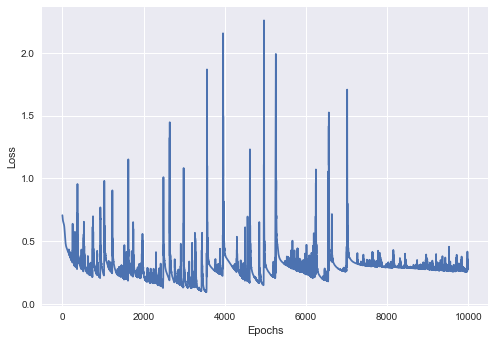

In [10]:
mlp = MLP()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr = 0.01, momentum = 0.9)

train_loss1 = []

for i in range(10000):
    i += 1
    yPred = mlp.forward(X_train)
    loss = criterion(yPred, y_train)
    train_loss1.append(loss)

    if i % 500 == 0:
        print("Epoch: {} Loss: {} ".format(i, loss.item()))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.style.use("seaborn")
plt.plot(range(10000), train_loss1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

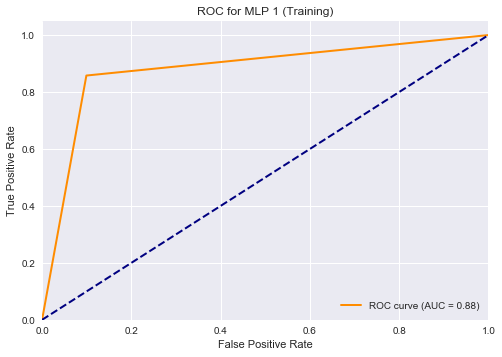

Training accuracy score for first MLP:  88.59934853420195
---
Training Classification Report for first MLP
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       403
           1       0.82      0.86      0.84       211

    accuracy                           0.89       614
   macro avg       0.87      0.88      0.88       614
weighted avg       0.89      0.89      0.89       614



In [11]:
# Accuracy score for Training data our First MLP

predictions=[]
for i,data in enumerate(X_train):
    y_pred=mlp(data)
    predictions.append(y_pred.argmax().item())
    
    
#Plot the respective ROC curve
fpr, tpr, _  = roc_curve(y_train, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MLP 1 (Training)')
plt.legend(loc="lower right")
plt.show()

acc_score = accuracy_score(y_train, predictions)
print("Training accuracy score for first MLP: ", acc_score*100)
print("---")
print("Training Classification Report for first MLP\n",classification_report(y_train, predictions))

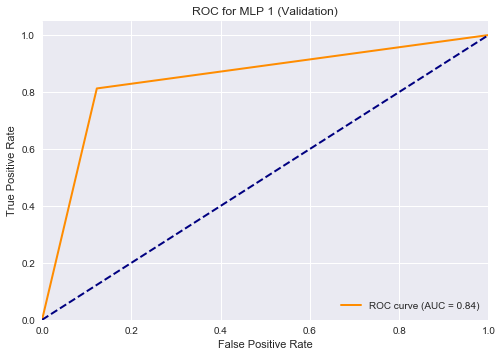

Validation accuracy score for first MLP:  85.71428571428571
---
Validation Classification Report for first MLP
               precision    recall  f1-score   support

           0       0.91      0.88      0.89       106
           1       0.75      0.81      0.78        48

    accuracy                           0.86       154
   macro avg       0.83      0.84      0.84       154
weighted avg       0.86      0.86      0.86       154



In [12]:
# Accuracy score for Validation data for our First MLP

predictions=[]
for i,data in enumerate(X_validation):
    y_pred=mlp(data)
    predictions.append(y_pred.argmax().item())
    
    
#Plot the respective ROC curve
fpr, tpr, _  = roc_curve(y_validation, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MLP 1 (Validation)')
plt.legend(loc="lower right")
plt.show()

acc_score = accuracy_score(y_validation, predictions)
print("Validation accuracy score for first MLP: ", acc_score*100)
print("---")
print("Validation Classification Report for first MLP\n",classification_report(y_validation, predictions))

In [13]:
# We will now run our grid search to see whether we can optimise our first MLP

net = NeuralNetClassifier(
    mlp,
    max_epochs = [100],
    lr = 0.01,
    criterion = CrossEntropyLoss,
    optimizer = optim.SGD,
    module__hiddenTwo = [25],
    module__hiddenThree = [35],
    module__hiddenFour = [35],
)

params = {
    'lr': [0.1, 0.9],
    'max_epochs': [100],
    'module__hiddenTwo': [10, 50],
    'module__hiddenThree': [10, 50],
    'module__hiddenFour': [10, 50],
    'optimizer__momentum': [0.1, 0.9]
}
    
gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy')

gs.fit(X_train, y_train)

     71           nan       0.6577           nan  0.0127
     72           nan       0.6577           nan  0.0126
     73           nan       0.6577           nan  0.0126
     74           nan       0.6577           nan  0.0126
     75           nan       0.6577           nan  0.0128
     76           nan       0.6577           nan  0.0132
     77           nan       0.6577           nan  0.0126
     78           nan       0.6577           nan  0.0132
     79           nan       0.6577           nan  0.0126
     80           nan       0.6577           nan  0.0132
     81           nan       0.6577           nan  0.0128
     82           nan       0.6577           nan  0.0124
     83           nan       0.6577           nan  0.0124
     84           nan       0.6577           nan  0.0130
     85           nan       0.6577           nan  0.0129
     86           nan       0.6577           nan  0.0129
     87           nan       0.6577           nan  0.0128
     88           nan       0.6

GridSearchCV(cv=10,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=MLP(
    (fc1): Linear(in_features=8, out_features=30, bias=True)
    (fc2): Linear(in_features=30, out_features=25, bias=True)
    (fc3): Linear(in_features=25, out_features=35, bias=True)
    (fc4): Linear(in_features=35, out_features=35, bias=True)
    (fc5): Linear(in_features=35, out_f...
    (fc6): Linear(in_features=35, out_features=35, bias=True)
    (output): Linear(in_features=35, out_features=2, bias=True)
  ),
  module__hiddenFour=[35],
  module__hiddenThree=[35],
  module__hiddenTwo=[25],
),
             param_grid={'lr': [0.1, 0.9], 'max_epochs': [100],
                         'module__hiddenFour': [10, 50],
                         'module__hiddenThree': [10, 50],
                         'module__hiddenTwo': [10, 50],
                         'optimizer__momentum': [0.1, 0.9]},
             refit=False, scoring='accuracy')

In [14]:
print("Best score from First Multilayer Perceptron Model:", gs.best_score_)
print("---")
print("Best parameters from First Multilayer Perceptron Model:", gs.best_params_)

Best score from First Multilayer Perceptron Model: 0.7474616604970915
---
Best parameters from First Multilayer Perceptron Model: {'lr': 0.1, 'max_epochs': 100, 'module__hiddenFour': 50, 'module__hiddenThree': 50, 'module__hiddenTwo': 50, 'optimizer__momentum': 0.1}


In [15]:
# We will now update our first MLP with the parameters obtained from our grid search

In [16]:
class MLPGS(nn.Module):
    def __init__(self,hiddenOne = 30, hiddenTwo = 10,
                 hiddenThree = 10, hiddenFour = 50, 
                 hiddenFive = 35, hiddenSix = 35):
        super(MLPGS, self).__init__()

        self.fc1 = nn.Linear(8, hiddenOne)
        self.fc2 = nn.Linear(hiddenOne, hiddenTwo)
        self.fc3 = nn.Linear(hiddenTwo, hiddenThree)
        self.fc4 = nn.Linear(hiddenThree, hiddenFour)
        self.fc5 = nn.Linear(hiddenFour, hiddenFive)
        self.fc6 = nn.Linear(hiddenFive, hiddenSix)
        self.output = nn.Linear(hiddenSix, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.output(x)
        return x

In [17]:
mlpGS = MLPGS()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlpGS.parameters(), lr = 0.01, momentum = 0.1)

Epoch: 10 Loss: 0.7009141445159912 
Epoch: 20 Loss: 0.6891663670539856 
Epoch: 30 Loss: 0.6779402494430542 
Epoch: 40 Loss: 0.666767954826355 
Epoch: 50 Loss: 0.6540783047676086 
Epoch: 60 Loss: 0.6412535905838013 
Epoch: 70 Loss: 0.6295948624610901 
Epoch: 80 Loss: 0.6182295083999634 
Epoch: 90 Loss: 0.6068590879440308 
Epoch: 100 Loss: 0.5952908992767334 


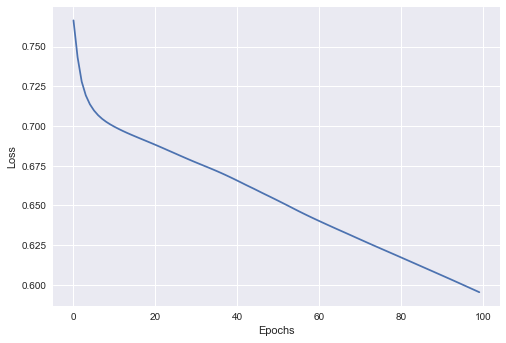

In [18]:
# Training Loss our first MLP with the parameters obtained from our grid search

train_loss1_gs = []

for i in range(100):
    i += 1

    optimizer.zero_grad()
    outputs = mlpGS(X_train)
    loss = criterion(outputs, y_train)
    train_loss1_gs.append(loss)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print("Epoch: {} Loss: {} ".format(i, loss.item()))

plt.style.use("seaborn")
plt.plot(range(100), train_loss1_gs)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

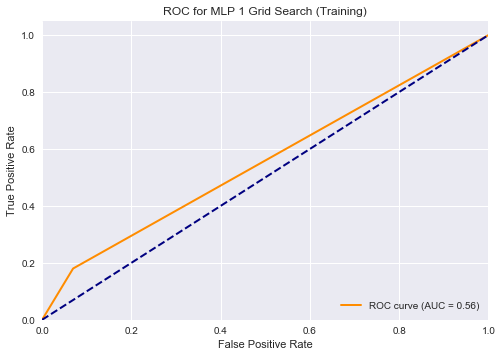

Training accuracy score for first MLP with Grid Search::  67.26384364820846
---
Training Classification Report for first MLP with Grid Search:
               precision    recall  f1-score   support

           0       0.68      0.93      0.79       403
           1       0.58      0.18      0.27       211

    accuracy                           0.67       614
   macro avg       0.63      0.56      0.53       614
weighted avg       0.65      0.67      0.61       614



In [19]:
# Accuracy score for Training data our First MLP with grid search parameters

predictions=[]
for i,data in enumerate(X_train):
    y_pred=mlpGS(data)
    predictions.append(y_pred.argmax().item())
    
    
#Plot the respective ROC curve
fpr, tpr, _  = roc_curve(y_train, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MLP 1 Grid Search (Training)')
plt.legend(loc="lower right")
plt.show()

acc_score = accuracy_score(y_train, predictions)
print("Training accuracy score for first MLP with Grid Search:: ", acc_score*100)
print("---")
print("Training Classification Report for first MLP with Grid Search:\n",classification_report(y_train, predictions))

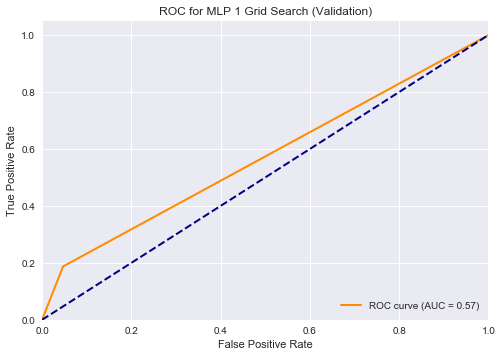

Validation accuracy score for first MLP with Grid Search:  71.42857142857143
---
Validation Classification Report for first MLP with Grid Search:
               precision    recall  f1-score   support

           0       0.72      0.95      0.82       106
           1       0.64      0.19      0.29        48

    accuracy                           0.71       154
   macro avg       0.68      0.57      0.56       154
weighted avg       0.70      0.71      0.66       154



In [20]:
# Accuracy score for Validation data our First MLP with grid search parameters

predictions=[]
for i,data in enumerate(X_validation):
    y_pred=mlpGS(data)
    predictions.append(y_pred.argmax().item())
    
    
#Plot the respective ROC curve
fpr, tpr, _  = roc_curve(y_validation, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MLP 1 Grid Search (Validation)')
plt.legend(loc="lower right")
plt.show()

acc_score = accuracy_score(y_validation, predictions)
print("Validation accuracy score for first MLP with Grid Search: ", acc_score*100)
print("---")
print("Validation Classification Report for first MLP with Grid Search:\n",classification_report(y_validation, predictions))

## Second Multi-Layer Perceptron Model 

#### For our second MLP, we will design network, train it and calculate it's loss. We will also calculate it's training and validation loss. After this, we will run a grid search on it to see whether we can obtain optimal parameters. We will then calculate it's training and validation loss to see whether it imrpoves against the inital design

In [21]:
# Unlike our first MLP, here we have fewer layers and are using the Hard Tanh activation function

class MLPTwo(nn.Module):
    def __init__(self,hiddenOne = 30, hiddenTwo = 10,
                                  hiddenThree = 50):
        super(MLPTwo, self).__init__()

        self.fc1 = nn.Linear(8, hiddenOne)
        self.fc2 = nn.Linear(hiddenOne, hiddenTwo)
        self.fc3 = nn.Linear(hiddenTwo, hiddenThree)
        self.output = nn.Linear(hiddenThree, 2)

    def forward(self, x):
        x = F.hardtanh(self.fc1(x))
        x = F.hardtanh(self.fc2(x))
        x = F.hardtanh(self.fc3(x))
        x = self.output(x)
        return x

In [22]:
# Unlike our fist MLP, we are using the AdamW optimizer

mlp_two = MLPTwo()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(mlp_two.parameters(), lr = 0.01, weight_decay=0.01)

Epoch: 500 Loss: 0.2597755789756775 
Epoch: 1000 Loss: 0.2562176287174225 
Epoch: 1500 Loss: 0.26555103063583374 
Epoch: 2000 Loss: 0.28747430443763733 
Epoch: 2500 Loss: 0.2543715238571167 
Epoch: 3000 Loss: 0.2288861870765686 
Epoch: 3500 Loss: 0.2920292019844055 
Epoch: 4000 Loss: 0.28955358266830444 
Epoch: 4500 Loss: 0.2875794768333435 
Epoch: 5000 Loss: 0.30664175748825073 
Epoch: 5500 Loss: 0.5614989399909973 
Epoch: 6000 Loss: 0.5429745316505432 
Epoch: 6500 Loss: 0.5677947998046875 
Epoch: 7000 Loss: 0.4474753737449646 
Epoch: 7500 Loss: 0.5158950090408325 
Epoch: 8000 Loss: 0.4515157639980316 
Epoch: 8500 Loss: 0.633804440498352 
Epoch: 9000 Loss: 0.6359951496124268 
Epoch: 9500 Loss: 0.6423317193984985 
Epoch: 10000 Loss: 0.6403188705444336 


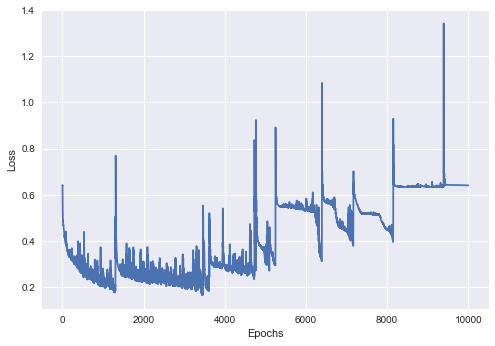

In [23]:
# Unlike our fist MLP, we are using the AdamW optimizer

train_loss2 = []

for i in range(10000):
    i += 1

    optimizer.zero_grad()
    outputs = mlp_two(X_train)
    loss = criterion(outputs, y_train)
    train_loss2.append(loss)
    loss.backward()
    optimizer.step()

    if i % 500 == 0:
        print("Epoch: {} Loss: {} ".format(i, loss.item()))
        
plt.style.use("seaborn")
plt.plot(range(10000), train_loss2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

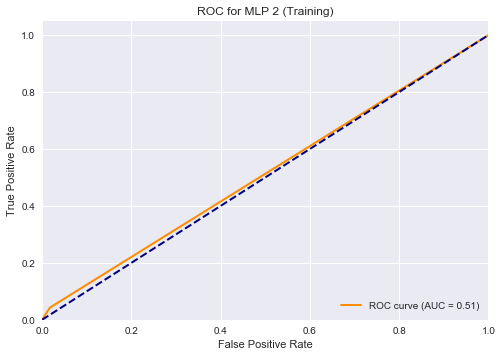

Training accuracy score for Second MLP:  65.96091205211727
---
Training Classification Report for Second MLP
               precision    recall  f1-score   support

           0       0.66      0.98      0.79       403
           1       0.56      0.04      0.08       211

    accuracy                           0.66       614
   macro avg       0.61      0.51      0.44       614
weighted avg       0.63      0.66      0.55       614



In [24]:
# Accuracy score for Training data our Second MLP

predictions=[]
for i,data in enumerate(X_train):
    y_pred=mlp_two(data)
    predictions.append(y_pred.argmax().item())
    
    
#Plot the respective ROC curve
fpr, tpr, _  = roc_curve(y_train, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MLP 2 (Training)')
plt.legend(loc="lower right")
plt.show()

acc_score = accuracy_score(y_train, predictions)
print("Training accuracy score for Second MLP: ", acc_score*100)
print("---")
print("Training Classification Report for Second MLP\n",classification_report(y_train, predictions))

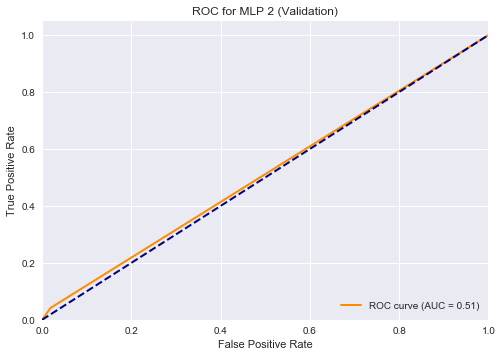

Validation accuracy score for Second MLP model:  68.83116883116884
---
Validation Classification Report for Second MLP
               precision    recall  f1-score   support

           0       0.69      0.98      0.81       106
           1       0.50      0.04      0.08        48

    accuracy                           0.69       154
   macro avg       0.60      0.51      0.44       154
weighted avg       0.63      0.69      0.58       154



In [25]:
# Accuracy score for Validation data for our Second MLP

predictions=[]
for i,data in enumerate(X_validation):
    y_pred=mlp_two(data)
    predictions.append(y_pred.argmax().item())
    
    
#Plot the respective ROC curve
fpr, tpr, _  = roc_curve(y_validation, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MLP 2 (Validation)')
plt.legend(loc="lower right")
plt.show()    


acc_score = accuracy_score(y_validation, predictions)
print("Validation accuracy score for Second MLP model: ", acc_score*100)
print("---")
print("Validation Classification Report for Second MLP\n",classification_report(y_validation, predictions))

In [26]:
# We will now run our grid search to see whether we can optimise our second MLP


net = NeuralNetClassifier(
    mlp_two,
    max_epochs = [100],
    lr = 0.01,
    criterion = CrossEntropyLoss,
    optimizer = optim.AdamW,
    module__hiddenTwo = [20],
    module__hiddenThree = [20])

params = {
    'lr': [0.1, 0.9],
    'max_epochs': [100],
    'module__hiddenTwo': [10, 50],
    'module__hiddenThree': [10, 50],
    'optimizer__weight_decay': [0.1, 0.9]
}    

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy')

gs.fit(X_train, y_train)

 75        0.6466       0.6577        0.6455  0.0122
     76        0.6473       0.6577        0.6428  0.0125
     77        0.6469       0.6577        0.6445  0.0126
     78        0.6469       0.6577        0.6428  0.0122
     79        0.6460       0.6577        0.6429  0.0122
     80        0.6460       0.6577        0.6429  0.0121
     81        0.6460       0.6577        0.6429  0.0126
     82        0.6462       0.6577        0.6434  0.0125
     83        0.6526       0.6577        0.6428  0.0121
     84        0.6454       0.6577        0.6427  0.0128
     85        0.6454       0.6577        0.6428  0.0126
     86        0.6456       0.6577        0.6427  0.0124
     87        0.6453       0.6577        0.6426  0.0121
     88        0.6462       0.6577        0.6426  0.0123
     89        0.6451       0.6577        0.6427  0.0200
     90        0.6453       0.6577        0.6427  0.0167
     91        0.6458       0.6577        0.6426  0.0126
     92        0.6453       0.6577 

GridSearchCV(cv=10,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=MLPTwo(
    (fc1): Linear(in_features=8, out_features=30, bias=True)
    (fc2): Linear(in_features=30, out_features=10, bias=True)
    (fc3): Linear(in_features=10, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=2, bias=True)
  ),
  module__hiddenThree=[20],
  module__hiddenTwo=[20],
),
             param_grid={'lr': [0.1, 0.9], 'max_epochs': [100],
                         'module__hiddenThree': [10, 50],
                         'module__hiddenTwo': [10, 50],
                         'optimizer__weight_decay': [0.1, 0.9]},
             refit=False, scoring='accuracy')

In [27]:
print("Best score from First Multilayer Perceptron Model:", gs.best_score_)
print("---")
print("Best parameters from First Multilayer Perceptron Model:", gs.best_params_)

Best score from First Multilayer Perceptron Model: 0.6563458487572712
---
Best parameters from First Multilayer Perceptron Model: {'lr': 0.1, 'max_epochs': 100, 'module__hiddenThree': 10, 'module__hiddenTwo': 10, 'optimizer__weight_decay': 0.1}


In [28]:
# We will now update our second MLP with the parameters obtained from our grid search

In [29]:
class MLPTwoGS(nn.Module):
    def __init__(self,hiddenOne = 30, hiddenTwo = 10,
                                  hiddenThree = 10):
        super(MLPTwoGS, self).__init__()

        self.fc1 = nn.Linear(8, hiddenOne)
        self.fc2 = nn.Linear(hiddenOne, hiddenTwo)
        self.fc3 = nn.Linear(hiddenTwo, hiddenThree)
        self.output = nn.Linear(hiddenThree, 2)

    def forward(self, x):
        x = F.hardtanh(self.fc1(x))
        x = F.hardtanh(self.fc2(x))
        x = F.hardtanh(self.fc3(x))
        x = self.output(x)
        return x

In [30]:
mlp_twoGS = MLPTwoGS()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(mlp_twoGS.parameters(), lr = 0.01, weight_decay=0.01)

Epoch: 10 Loss: 0.5339370369911194 
Epoch: 20 Loss: 0.4620608985424042 
Epoch: 30 Loss: 0.43737396597862244 
Epoch: 40 Loss: 0.4219445288181305 
Epoch: 50 Loss: 0.4126299321651459 
Epoch: 60 Loss: 0.4029124677181244 
Epoch: 70 Loss: 0.3968976140022278 
Epoch: 80 Loss: 0.39687585830688477 
Epoch: 90 Loss: 0.38783586025238037 
Epoch: 100 Loss: 0.3885186016559601 


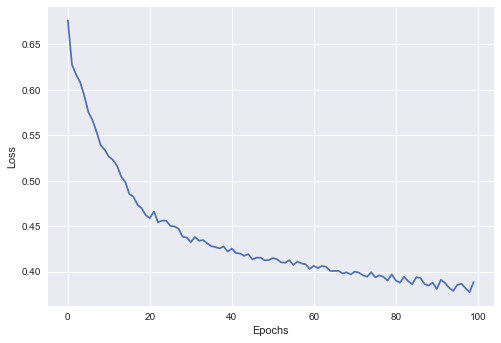

In [31]:
# Training Loss 

train_loss2_gs = []

for i in range(100):
    i += 1

    optimizer.zero_grad()
    outputs = mlp_twoGS(X_train)
    loss = criterion(outputs, y_train)
    train_loss2_gs.append(loss)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print("Epoch: {} Loss: {} ".format(i, loss.item()))

plt.style.use("seaborn")
plt.plot(range(100), train_loss2_gs)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

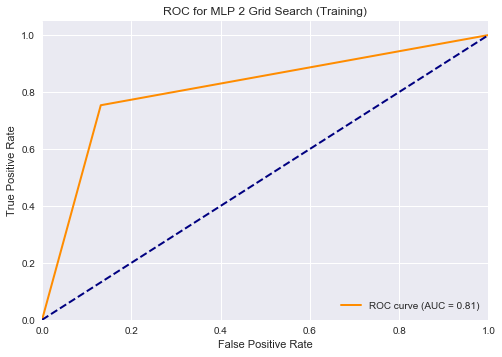

Training accuracy score for Second MLP with Grid Search::  82.89902280130293
---
Training Classification Report for Second MLP with Grid Search:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       403
           1       0.75      0.75      0.75       211

    accuracy                           0.83       614
   macro avg       0.81      0.81      0.81       614
weighted avg       0.83      0.83      0.83       614



In [32]:
# Accuracy score for Training data our Second MLP with grid search parameters

predictions=[]
for i,data in enumerate(X_train):
    y_pred=mlp_twoGS(data)
    predictions.append(y_pred.argmax().item())
    
    
#Plot the respective ROC curve
fpr, tpr, _  = roc_curve(y_train, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MLP 2 Grid Search (Training)')
plt.legend(loc="lower right")
plt.show()

acc_score = accuracy_score(y_train, predictions)
print("Training accuracy score for Second MLP with Grid Search:: ", acc_score*100)
print("---")
print("Training Classification Report for Second MLP with Grid Search:\n",classification_report(y_train, predictions))

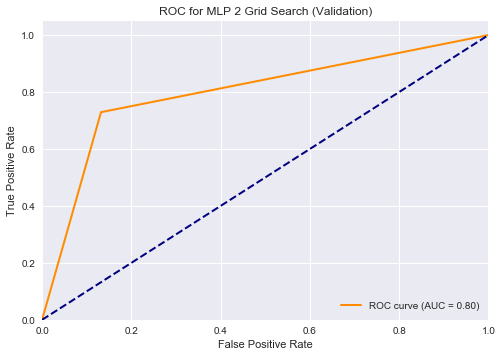

Validation accuracy score for Second MLP with Grid Search::  82.46753246753246
---
Validation Classification Report for Second MLP
               precision    recall  f1-score   support

           0       0.88      0.87      0.87       106
           1       0.71      0.73      0.72        48

    accuracy                           0.82       154
   macro avg       0.80      0.80      0.80       154
weighted avg       0.83      0.82      0.83       154



In [33]:
# Accuracy score for Validation data our Second MLP with grid search parameters

predictions=[]
for i,data in enumerate(X_validation):
    y_pred=mlp_twoGS(data)
    predictions.append(y_pred.argmax().item())

    
#Plot the respective ROC curve
fpr, tpr, _  = roc_curve(y_validation, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MLP 2 Grid Search (Validation)')
plt.legend(loc="lower right")
plt.show()    

acc_score = accuracy_score(y_validation, predictions)
print("Validation accuracy score for Second MLP with Grid Search:: ", acc_score*100)
print("---")
print("Validation Classification Report for Second MLP\n",classification_report(y_validation, predictions))

## Third Multi-Layer Perceptron Model 

#### For our third and final MLP, we will design network, train it and calculate it's loss. We will also calculate it's training and validation loss. After this, we will run a grid search on it to see whether we can obtain optimal parameters. We will then calculate it's training and validation loss to see whether it imrpoves against the inital design

In [34]:
# Unlike our second MLP, here we have fewer layers and are using the Leaky ReLu activation function

class MLPThree(nn.Module):
    def __init__(self,hiddenOne = 25, hiddenTwo = 20):
        super().__init__()
        self.fc1 = nn.Linear(8,hiddenOne)
        self.fc2 = nn.Linear(hiddenOne,hiddenTwo)
        self.output = nn.Linear(hiddenTwo,2)
    def forward(self,x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.output(x)
        return x

Epoch: 500 Loss: 0.23773491382598877 
Epoch: 1000 Loss: 0.25707563757896423 
Epoch: 1500 Loss: 0.18769241869449615 
Epoch: 2000 Loss: 0.1894296258687973 
Epoch: 2500 Loss: 0.2098757028579712 
Epoch: 3000 Loss: 0.2950398623943329 
Epoch: 3500 Loss: 0.2587466537952423 
Epoch: 4000 Loss: 0.23221583664417267 
Epoch: 4500 Loss: 0.24366794526576996 
Epoch: 5000 Loss: 0.22536590695381165 
Epoch: 5500 Loss: 0.23089487850666046 
Epoch: 6000 Loss: 0.19284440577030182 
Epoch: 6500 Loss: 0.17670166492462158 
Epoch: 7000 Loss: 0.16507574915885925 
Epoch: 7500 Loss: 0.3356645703315735 
Epoch: 8000 Loss: 0.28729769587516785 
Epoch: 8500 Loss: 0.2731744945049286 
Epoch: 9000 Loss: 0.3828602135181427 
Epoch: 9500 Loss: 0.33368542790412903 
Epoch: 10000 Loss: 0.32126733660697937 


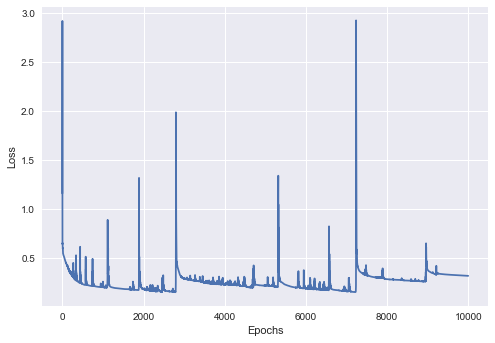

In [35]:
mlp_three = MLPThree()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(mlp_three.parameters(), lr = 0.01, weight_decay=0.01)

train_loss3 = []

for i in range(10000):
    i += 1

    optimizer.zero_grad()
    outputs = mlp_three(X_train)
    loss = criterion(outputs, y_train)
    train_loss3.append(loss)
    loss.backward()
    optimizer.step()

    if i % 500 == 0:
        print("Epoch: {} Loss: {} ".format(i, loss.item()))
        
plt.style.use("seaborn")
plt.plot(range(10000), train_loss3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

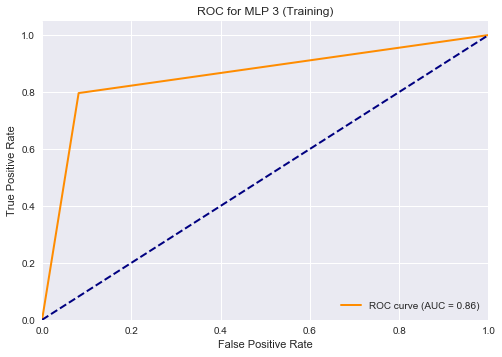

Training accuracy score for Third MLP:  87.62214983713355
---
Training Classification Report for Third MLP
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       403
           1       0.84      0.80      0.82       211

    accuracy                           0.88       614
   macro avg       0.87      0.86      0.86       614
weighted avg       0.88      0.88      0.88       614



In [36]:
# Accuracy score for Training data our Third MLP

predictions=[]
for i,data in enumerate(X_train):
    y_pred=mlp_three(data)
    predictions.append(y_pred.argmax().item())
    
      
#Plot the respective ROC curve
fpr, tpr, _  = roc_curve(y_train, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MLP 3 (Training)')
plt.legend(loc="lower right")
plt.show() 

acc_score = accuracy_score(y_train, predictions)
print("Training accuracy score for Third MLP: ", acc_score*100)
print("---")
print("Training Classification Report for Third MLP\n",classification_report(y_train, predictions))

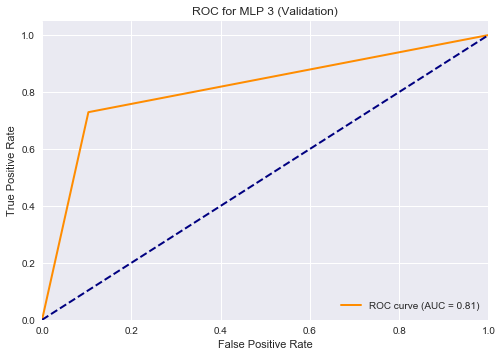

Validation accuracy score for Third MLP:  84.4155844155844
---
Validation Classification Report for Third MLP
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       106
           1       0.76      0.73      0.74        48

    accuracy                           0.84       154
   macro avg       0.82      0.81      0.82       154
weighted avg       0.84      0.84      0.84       154



In [37]:
# Accuracy score for Validation data for our Third MLP

predictions=[]
for i,data in enumerate(X_validation):
    y_pred=mlp_three(data)
    predictions.append(y_pred.argmax().item())
    
    
#Plot the respective ROC curve
fpr, tpr, _  = roc_curve(y_validation, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MLP 3 (Validation)')
plt.legend(loc="lower right")
plt.show()

acc_score = accuracy_score(y_validation, predictions)
print("Validation accuracy score for Third MLP: ", acc_score*100)
print("---")
print("Validation Classification Report for Third MLP\n",classification_report(y_validation, predictions))

In [38]:
# We will now run our grid search to see whether we can optimise our Third MLP


net = NeuralNetClassifier(
    mlp_three,
    max_epochs = [100],
    lr = 0.01,
    criterion = CrossEntropyLoss,
    optimizer = optim.AdamW,
    module__hiddenTwo = [20])

params = {
    'lr': [0.1, 0.9],
    'max_epochs': [100],
    'module__hiddenTwo': [10, 50],
    'optimizer__weight_decay': [0.1, 0.9]
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy')

gs.fit(X_train, y_train)

       0.6577        0.6457  0.0107
     19        0.6468       0.6577        0.6456  0.0109
     20        0.6467       0.6577        0.6455  0.0109
     21        0.6466       0.6577        0.6454  0.0111
     22        0.6465       0.6577        0.6453  0.0107
     23        0.6464       0.6577        0.6452  0.0111
     24        0.6463       0.6577        0.6451  0.0106
     25        0.6463       0.6577        0.6450  0.0111
     26        0.6462       0.6577        0.6449  0.0109
     27        0.6461       0.6577        0.6449  0.0113
     28        0.6461       0.6577        0.6448  0.0108
     29        0.6460       0.6577        0.6447  0.0109
     30        0.6459       0.6577        0.6447  0.0109
     31        0.6459       0.6577        0.6446  0.0110
     32        0.6458       0.6577        0.6445  0.0108
     33        0.6458       0.6577        0.6445  0.0130
     34        0.6457       0.6577        0.6444  0.0108
     35        0.6457       0.6577        0.6444  0.

GridSearchCV(cv=10,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=MLPThree(
    (fc1): Linear(in_features=8, out_features=25, bias=True)
    (fc2): Linear(in_features=25, out_features=20, bias=True)
    (output): Linear(in_features=20, out_features=2, bias=True)
  ),
  module__hiddenTwo=[20],
),
             param_grid={'lr': [0.1, 0.9], 'max_epochs': [100],
                         'module__hiddenTwo': [10, 50],
                         'optimizer__weight_decay': [0.1, 0.9]},
             refit=False, scoring='accuracy')

In [39]:
print("Best score from Third Multilayer Perceptron Model:", gs.best_score_)
print("---")
print("Best parameters from Third Multilayer Perceptron Model:", gs.best_params_)

Best score from Third Multilayer Perceptron Model: 0.7426758328926495
---
Best parameters from Third Multilayer Perceptron Model: {'lr': 0.1, 'max_epochs': 100, 'module__hiddenTwo': 10, 'optimizer__weight_decay': 0.1}


In [40]:
# We will now update our Third MLP with the parameters obtained from our grid search

In [41]:
class MLPThreeGS(nn.Module):
    def __init__(self,hiddenOne = 25, hiddenTwo = 50):
        super(MLPThreeGS, self).__init__()
        self.fc1 = nn.Linear(8,hiddenOne)
        self.fc2 = nn.Linear(hiddenOne,hiddenTwo)
        self.output = nn.Linear(hiddenTwo,2)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [42]:
mlp_threeGS = MLPThreeGS()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(mlp_threeGS.parameters(), lr = 0.01, weight_decay=0.01)

Epoch: 10 Loss: 0.8175811171531677 
Epoch: 20 Loss: 1.364755630493164 
Epoch: 30 Loss: 0.6081274747848511 
Epoch: 40 Loss: 0.6040929555892944 
Epoch: 50 Loss: 0.539986252784729 
Epoch: 60 Loss: 0.5260307192802429 
Epoch: 70 Loss: 0.5085002779960632 
Epoch: 80 Loss: 0.4943230450153351 
Epoch: 90 Loss: 0.47943225502967834 
Epoch: 100 Loss: 0.4657061994075775 


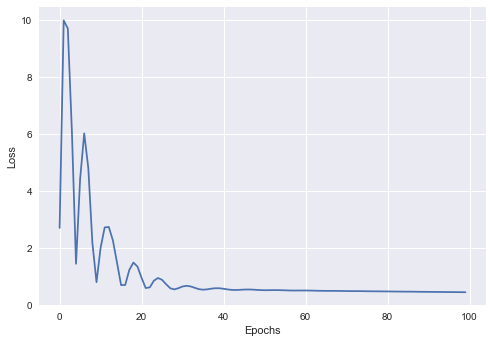

In [43]:
# Training Loss 

train_loss3_gs = []

for i in range(100):
    i += 1

    optimizer.zero_grad()
    outputs = mlp_threeGS(X_train)
    loss = criterion(outputs, y_train)
    train_loss3_gs.append(loss)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print("Epoch: {} Loss: {} ".format(i, loss.item()))

plt.style.use("seaborn")
plt.plot(range(100), train_loss3_gs)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

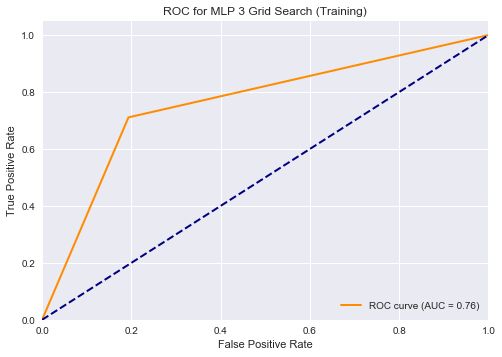

Training accuracy score for Third MLP with Grid Search::  77.36156351791531
---
Training Classification Report for Third MLP with Grid Search:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82       403
           1       0.66      0.71      0.68       211

    accuracy                           0.77       614
   macro avg       0.75      0.76      0.75       614
weighted avg       0.78      0.77      0.78       614



In [44]:
# Accuracy score for Training data our Third MLP with grid search parameters

predictions=[]
for i,data in enumerate(X_train):
    y_pred=mlp_threeGS(data)
    predictions.append(y_pred.argmax().item())
    
    
#Plot the respective ROC curve

fpr, tpr, _  = roc_curve(y_train, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MLP 3 Grid Search (Training)')
plt.legend(loc="lower right")
plt.show()

acc_score = accuracy_score(y_train, predictions)
print("Training accuracy score for Third MLP with Grid Search:: ", acc_score*100)
print("---")
print("Training Classification Report for Third MLP with Grid Search:\n",classification_report(y_train, predictions))

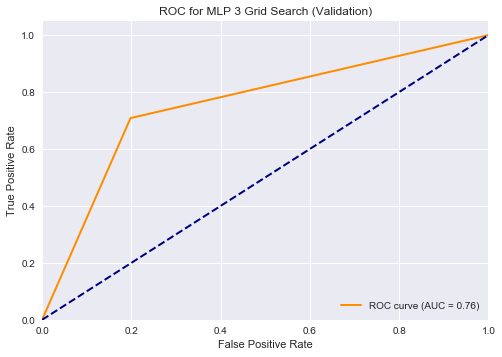

Validation accuracy score for Third MLP with Grid Search::  77.27272727272727
---
Validation Classification Report for Third MLP with Grid Search:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83       106
           1       0.62      0.71      0.66        48

    accuracy                           0.77       154
   macro avg       0.74      0.76      0.74       154
weighted avg       0.78      0.77      0.78       154



In [45]:
# Accuracy score for Validation data our Third MLP with grid search parameters

predictions=[]
for i,data in enumerate(X_validation):
    y_pred=mlp_threeGS(data)
    predictions.append(y_pred.argmax().item())
    
#Plot the respective ROC curve
    
fpr, tpr, _  = roc_curve(y_validation, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MLP 3 Grid Search (Validation)')
plt.legend(loc="lower right")
plt.show()
    
    
acc_score = accuracy_score(y_validation, predictions)
print("Validation accuracy score for Third MLP with Grid Search:: ", acc_score*100)
print("---")
print("Validation Classification Report for Third MLP with Grid Search:\n",classification_report(y_validation, predictions))

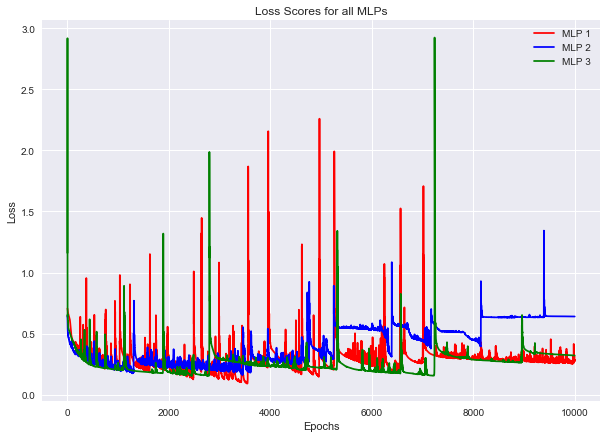

In [46]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(range(10000), train_loss1, color = "red", label = "MLP 1")
ax.plot(range(10000), train_loss2, color = "blue", label = "MLP 2")
ax.plot(range(10000), train_loss3, color = "green", label = "MLP 3")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Scores for all MLPs")
plt.legend()

It's clear that our MLPs showcase some level of unstability even after surpassing a large number of epochs.

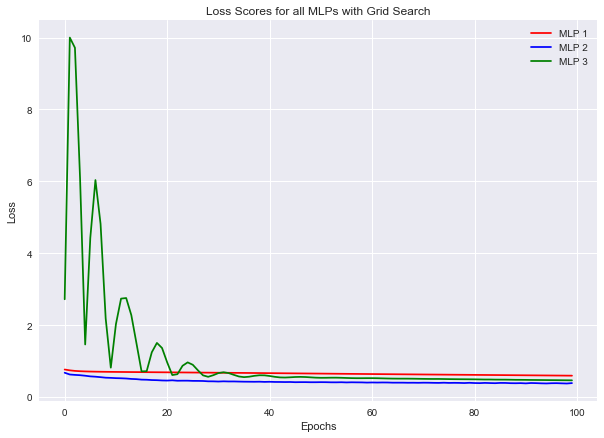

In [47]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(range(100), train_loss1_gs, color = "red", label = "MLP 1")
ax.plot(range(100), train_loss2_gs, color = "blue", label = "MLP 2")
ax.plot(range(100), train_loss3_gs, color = "green", label = "MLP 3")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Scores for all MLPs with Grid Search")
plt.legend()

# Conclusion

After designing three MLPs and conducting a grid search on each one, we can conclude that our third MLP (without grid search) is the most optimal given it has acheived a relatively good training and validation accuracy scores as well as the most stable training loss. This comes as a slight surpise given it did not use paramters obtained via Grid Search. With regards to the Loss Scores above, we see that MLP 3 performs optimally with and without grid search. 

## Saving our optimal MLP model

In [48]:
import pickle

with open("optimal_mlp", "wb") as op_mlp:
    pickle.dump(mlp_three, op_mlp)